# How to Train Segformer on Custom Data

This notebook shows training on **your own custom masks** for the SegFormer model as implemented in [the SegFormer paper](https://arxiv.org/pdf/2105.15203.pdf).

### Accompanying Blog Post

We recommend that you follow along in this notebook while reading the blog post on [How to Train Segformer](blog.roboflow.com/how-to-train-segformer-on-a-custom-dataset/), concurrently.


In [ ]:
#!pip install -q pytorch-lightning transformers datasets roboflow huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from datasets import load_metric
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from pytorch_lightning.callbacks import ModelCheckpoint
# from transformers import Train


/home/ec2-user/anaconda3/envs/python310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# from huggingface_hub import Repository
# repo = Repository("segFormerTst", "doc2txt/segFormerTst")

In [ ]:
# from roboflow import Roboflow
# rf = Roboflow(api_key="HUBAAfRrsHWybDdGgXbg")
# project = rf.workspace("paul-guerrie-tang1").project("balloons-geknh")
# dataset = project.version(1).download("png-mask-semantic")
# dataset.location

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Balloons-1 in png-mask-semantic:: 100%|██████████| 155/155 [00:00<00:00, 3099.25it/s]


'/content/Balloons-1'

In [2]:
import requests
import zipfile
from io import BytesIO

# Specify the URL of the zip file
url = 'https://doc2txt-images.s3.eu-west-3.amazonaws.com/dataset.zip'  # Replace with the actual URL

# Download the zip file using requests
response = requests.get(url)

# Check for successful download
response.raise_for_status()  # Raises an exception for error status codes

# Create a zip file object in memory
zip_ref = zipfile.ZipFile(BytesIO(response.content))

# Extract all files to the current directory
zip_ref.extractall()

# Close the zip file object
zip_ref.close()

print('Zip file downloaded and extracted successfully!')


Zip file downloaded and extracted successfully!


In [4]:
from PIL import Image
import os

import cv2

def resize_images(image_dir, output_dir=None, prefix="", resize_mode=Image.Resampling.LANCZOS):
  """
  Resizes all images in a directory to 512x512.

  Args:
      image_dir (str): Path to the directory containing images.
      output_dir (str, optional): Path to the directory for saving resized images. Defaults to None, which saves in the original directory.
      prefix (str, optional): Prefix to add to the resized image filenames. Defaults to "resized_".
      resize_mode (int, optional): Mode for resizing (e.g., Image.ANTIALIAS for smooth scaling). Defaults to Image.ANTIALIAS.
  """

  # Check if directory exists
  if not os.path.isdir(image_dir):
    raise ValueError(f"Image directory '{image_dir}' does not exist.")

  # Create output directory if not specified
  if not output_dir:
    output_dir = image_dir

  # Loop through files in the directory
  for filename in os.listdir(image_dir):
    # Check if it's a file
    if os.path.isfile(os.path.join(image_dir, filename)):
      # Open the image
      try:
        img = Image.open(os.path.join(image_dir, filename))
      except OSError as e:
        print(f"Error opening image '{filename}': {e}")
        continue

      # Resize the image
      resized_img = img.resize((512, 512), resize_mode)

      # Generate new filename with prefix
      new_filename = f"{prefix}{filename}"
      if "_mask" in filename:
        resized_img = np.array(resized_img)
        resized_img[resized_img>0] = 1
        cv2.imwrite(os.path.join(output_dir, new_filename), resized_img)
      else:
        # Save the resized image
        try:
          resized_img.save(os.path.join(output_dir, new_filename))
          print(f"Image '{filename}' resized and saved as '{new_filename}'")
        except OSError as e:
          print(f"Error saving resized image '{filename}': {e}")



In [5]:
dataset_location ="./dataset"
train_dataset = resize_images(f"{dataset_location}/train/")
val_dataset = resize_images(f"{dataset_location}/valid/")
test_dataset = resize_images(f"{dataset_location}/test/")

Error opening image '.DS_Store': cannot identify image file './dataset/train/.DS_Store'
Image '8.png' resized and saved as '8.png'
Image '9.png' resized and saved as '9.png'
Image '14.png' resized and saved as '14.png'
Image '28.png' resized and saved as '28.png'
Image '29.png' resized and saved as '29.png'
Image '15.png' resized and saved as '15.png'
Image '17.png' resized and saved as '17.png'
Image '16.png' resized and saved as '16.png'
Image '12.png' resized and saved as '12.png'
Image '13.png' resized and saved as '13.png'
Image '39.png' resized and saved as '39.png'
Image '10.png' resized and saved as '10.png'
Image '38.png' resized and saved as '38.png'
Image '35.png' resized and saved as '35.png'
Image '21.png' resized and saved as '21.png'
Image '20.png' resized and saved as '20.png'
Image '22.png' resized and saved as '22.png'
Image '36.png' resized and saved as '36.png'
Image '37.png' resized and saved as '37.png'
Image '23.png' resized and saved as '23.png'
Image '33.png' r

In [6]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annota SegformerForSemanticSegmentationtions.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f and '_mask' not in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '_mask.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [10]:
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, id2label, checkpoint_path=None, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=100):
        super(SegformerFinetuner, self).__init__()
        self.validation_step_outputs = []
        self.test_step_outputs = []
        self.id2label = id2label
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = len(id2label.keys())
        self.label2id = {v:k for k,v in self.id2label.items()}

        if checkpoint_path is None:
          checkpoint_path = "nvidia/mit-b0"
          # checkpoint_path = "nvidia/segformer-b0-finetuned-ade-512-512"

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            checkpoint_path,
            return_dict=False,
            num_labels=self.num_classes,
            id2label=self.id2label,
            label2id=self.label2id,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = load_metric("mean_iou")
        self.val_mean_iou = load_metric("mean_iou")
        self.test_mean_iou = load_metric("mean_iou")

    def forward(self, images, masks):
        outputs = self.model(pixel_values=images, labels=masks)
        return(outputs)

    def training_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        if batch_nb % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes,
                ignore_index=255,
                reduce_labels=False,
            )

            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}

            for k,v in metrics.items():
                self.log(k,v)

            return(metrics)
        else:
            return({'loss': loss})

    def validation_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        self.validation_step_outputs.append(loss)

        return({'val_loss': loss})

    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        metrics = self.val_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        val_mean_iou = metrics["mean_iou"]
        val_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"val_loss": avg_val_loss, "val_mean_iou":val_mean_iou, "val_mean_accuracy":val_mean_accuracy}
        for k,v in metrics.items():
            self.log(k,v)
        self.validation_step_outputs.clear()  # free memory
        return metrics

    def test_step(self, batch, batch_nb):

        images, masks = batch['pixel_values'], batch['labels']

        outputs = self(images, masks)

        loss, logits = outputs[0], outputs[1]

        upsampled_logits = nn.functional.interpolate(
            logits,
            size=masks.shape[-2:],
            mode="bilinear",
            align_corners=False
        )

        predicted = upsampled_logits.argmax(dim=1)

        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(),
            references=masks.detach().cpu().numpy()
        )
        self.test_step_outputs.append(loss)
        return({'test_loss': loss})

    def on_test_epoch_end(self):
        metrics = self.test_mean_iou.compute(
              num_labels=self.num_classes,
              ignore_index=255,
              reduce_labels=False,
          )

        avg_test_loss = torch.stack(self.test_step_outputs).mean()
        test_mean_iou = metrics["mean_iou"]
        test_mean_accuracy = metrics["mean_accuracy"]

        metrics = {"test_loss": avg_test_loss, "test_mean_iou":test_mean_iou, "test_mean_accuracy":test_mean_accuracy}

        for k,v in metrics.items():
            self.log(k,v)
        self.test_step_outputs.clear()  # free memory
        return metrics

    def configure_optimizers(self):
        return torch.optim.Adam([p for p in self.parameters() if p.requires_grad], lr=2e-05, eps=1e-08)

    def train_dataloader(self):
        return self.train_dl

    def val_dataloader(self):
        return self.val_dl

    def test_dataloader(self):
        return self.test_dl




In [11]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
feature_extractor.reduce_labels = False
feature_extractor.size = 128
dataset_location ="./dataset"
train_dataset = SemanticSegmentationDataset(f"{dataset_location}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset_location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset_location}/test/", feature_extractor)

batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

# checkpoint_path = "doc2txt/segFormerTst"

segformer_finetuner = SegformerFinetuner(
    train_dataset.id2label,
    # checkpoint_path=checkpoint_path,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    metrics_interval=10,

)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_fuse.weight', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_7611/1383103703.py:29: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, 

In [12]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00,
    patience=10,
    verbose=False,
    mode="min",
)

checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_loss",
    )


max_epochs = 10
trainer = pl.Trainer(
    max_epochs = max_epochs,
    accelerator="auto",
    devices="auto",
    callbacks=[early_stop_callback,checkpoint_callback],
    log_every_n_steps=5
)
trainer.fit(segformer_finetuner)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M 
-----------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)


Epoch 9: 100%|██████████| 6/6 [00:13<00:00,  0.44it/s, v_num=2]            

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 6/6 [00:13<00:00,  0.44it/s, v_num=2]


In [ ]:
#segformer_finetuner.model.push_to_hub("doc2txt/segFormerTst")

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/doc2txt/segFormerTst/commit/cb3fbb8965df817ad64ee0c11dd4bb363de57442', commit_message='Upload SegformerForSemanticSegmentation', commit_description='', oid='cb3fbb8965df817ad64ee0c11dd4bb363de57442', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

In [13]:
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at /home/ec2-user/work/tstSegFormer/lightning_logs/version_2/checkpoints/epoch=9-step=60.ckpt
Loaded model weights from the checkpoint at /home/ec2-user/work/tstSegFormer/lightning_logs/version_2/checkpoints/epoch=9-step=60.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/python310/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ec2-user/anaconda3/envs/python310/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ec2-user/anaconda3/envs/python310/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_7611/44001182.py", line 31, in __getitem__
    segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))
IndexError: list index out of range


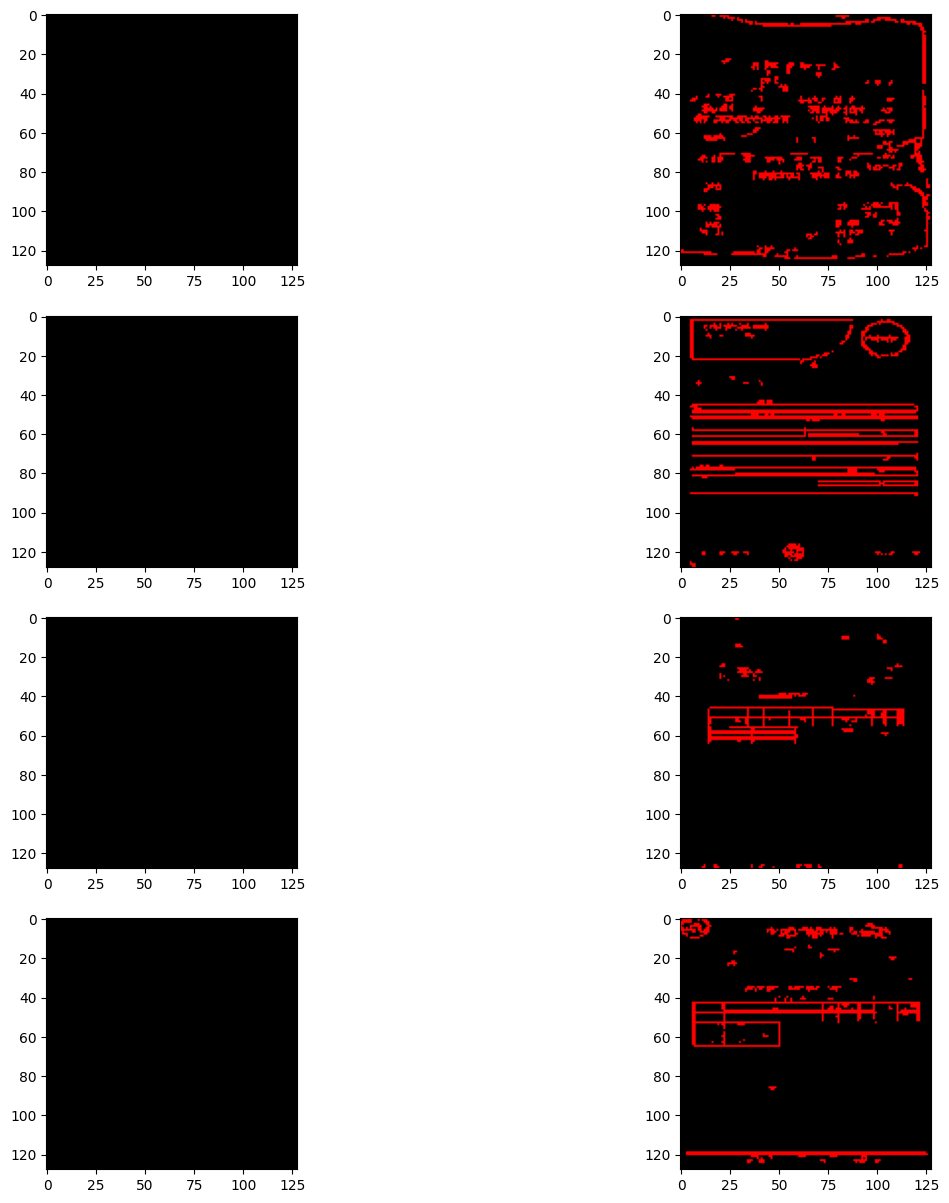

In [24]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

for batch in val_dataloader:
# for batch in test_dataloader:
    images, masks = batch['pixel_values'], batch['labels']
    outputs = segformer_finetuner.model(images, masks)

    loss, logits = outputs[0], outputs[1]

    upsampled_logits = nn.functional.interpolate(
        logits,
        size=masks.shape[-2:],
        mode="bilinear",
        align_corners=False
    )
    predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
    masks = masks.cpu().numpy()

n_plots = 4
from matplotlib import pyplot as plt
f, axarr = plt.subplots(n_plots,2)
f.set_figheight(15)
f.set_figwidth(15)
for i in range(n_plots):
    axarr[i,0].imshow(prediction_to_vis(predicted_mask[i,:,:]))
    axarr[i,1].imshow(prediction_to_vis(masks[i,:,:]))


In [30]:
#Predict on a test image and overlay the mask on the original image
test_idx = 0
input_image_file = os.path.join(test_dataset.root_dir,test_dataset.images[test_idx])
input_image = Image.open(input_image_file)
test_batch = test_dataset[test_idx]
images, _ = test_batch['pixel_values'], test_batch['labels']
images = torch.unsqueeze(images, 0)
# masks = torch.unsqueeze(masks, 0)
outputs = segformer_finetuner.model(images)

logits = outputs[0]

upsampled_logits = nn.functional.interpolate(
    logits,
    size=masks.shape[-2:],
    mode="bilinear",
    align_corners=False
)
predicted_mask = upsampled_logits.argmax(dim=1).cpu().numpy()
mask = prediction_to_vis(np.squeeze(predicted_mask))
mask = mask.resize(input_image.size)
mask = mask.convert("RGBA")
input_image = input_image.convert("RGBA")
overlay_img = Image.blend(input_image, mask, 0.5)

ValueError: Could not save to JPEG for display

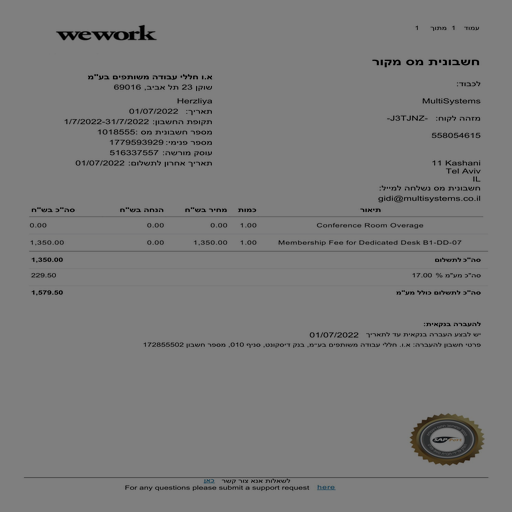

In [31]:
overlay_img